# Classifying Fashion-MNIST

You'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). Fashion-MNIST is a set of 28x28 greyscale images of clothes. 

In this notebook, you'll build your own neural network to predict the type of clothing in the image.

First up, we need to get our dataset. This is provided through the `torchvision` package. The code below will download the MNIST dataset, then create training and test datasets for us.

In [2]:
!pip install torchvision

In [3]:
import torch
from torchvision import datasets, transforms
import warnings
import matplotlib.pyplot as plt
import numpy as np

warnings.simplefilter("ignore")

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. Later, we'll use this to loop through the dataset for training, like

```python
for image, label in trainloader:
    ## do things with images and labels
```

You'll notice I created the `trainloader` with a batch size of 64, and `shuffle=True`. The batch size is the number of images we get in one iteration from the data loader and pass through our network, often called a *batch*. And `shuffle=True` tells it to shuffle the dataset every time we start going through the data loader again. 

In [4]:
def imshow(image, ax=None, title=None, normalize=True):
    """ Function is display the image"""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

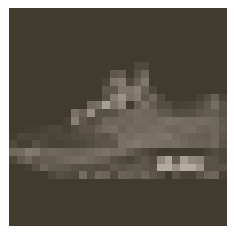

In [5]:
image, label = next(iter(trainloader))
imshow(image[0,:]);

### Labels
Each training and test example is assigned to one of the following labels

|Label|Description|
|-----|-----------|
| 0 | T-shirt/top|
| 1 | Trouser |
| 2 | Pullover|
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot|

In [6]:
# Unique classes
label.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [7]:
image.shape

torch.Size([64, 1, 28, 28])

## Building networks with PyTorch

PyTorch provides a module [`nn`](https://pytorch.org/docs/stable/nn.html) that makes building networks much simpler.  Here you should define your network. Each image is 28x28 which is a total of 784 pixels, and there are 10 classes.

In [8]:
from torch import nn, optim
import torch.nn.functional as F

In [9]:
# Define your network architecture here
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 256)
        self.hidden2 = nn.Linear(256, 128)
        self.hidden3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10)  # Output layer, 10 units - one for each class
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.log_softmax(self.output(x), dim=1)
        
        return x

Let's go through this bit by bit.

```python
class Classifier(nn.Module):
```

Here we're inheriting from `nn.Module`. Combined with `super().__init__()` this creates a class that tracks the architecture and provides a lot of useful methods and attributes. It is mandatory to inherit from `nn.Module` when you're creating a class for your network. The name of the class itself can be anything.

```python
self.hidden1 = nn.Linear(784, 256)
```

This line creates a module for a linear transformation, $x\mathbf{W} + b$, with 784 inputs and 256 outputs and assigns it to `self.hidden1`. The module automatically creates the weight and bias tensors which we'll use in the `forward` method. You can access the weight and bias tensors once the network (`net`) is created with `net.hidden1.weight` and `net.hidden1.bias`.

```python
self.output = nn.Linear(64, 10)
```

Similarly, this creates another linear transformation with 64 inputs and 10 outputs.


```python
def forward(self, x):
```

PyTorch networks created with `nn.Module` must have a `forward` method defined. It takes in a tensor `x` and passes it through the operations defined in the `__init__` method.

```python
x = x.view(x.shape[0], -1)
x = F.relu(self.hidden1(x))
x = F.relu(self.hidden2(x))
x = F.relu(self.hidden3(x))
x = F.log_softmax(self.output(x), dim=1)
```

Here the input tensor `x` is passed through each operation and reassigned to `x`. First, we flattened the 28x28 2D images into 1D vectors. Then, the input tensor goes through the first hidden layer, then a ReLU activation function, then into the next hidden layer and ReLU activation function, and so on, finally through the softmax function to calculate the class probabilities

It doesn't matter what you name the variables here, as long as the inputs and outputs of the operations match the network architecture you want to build. The order in which you define things in the `__init__` method doesn't matter, but you'll need to sequence the operations correctly in the `forward` method.

Now we can create a `Network` object.

In [10]:
#Create the network
model = Classifier()

Let's start by seeing how we calculate the loss with PyTorch. Through the nn module, PyTorch provides several loss functions such as negative log likelihood loss. ([`nn.NLLLoss`](https://pytorch.org/docs/stable/nn.html#nllloss)). You'll usually see the loss assigned to `criterion`.

In [11]:
#define the criterion and optimizer
criterion = nn.NLLLoss()

### Autograd & Optimizer

Now that we know how to calculate a loss, how do we use it to perform backpropagation? Torch provides a module, `autograd`, for automatically calculating the gradients of tensors. We can use it to calculate the gradients of all our parameters with respect to the loss.  To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad = True` on a tensor.

When we create a network with PyTorch, all of the parameters are initialized with requires_grad = True. This means that when we calculate the loss and call loss.backward(), the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent.

We will use an optimizer to update the weights with the gradients. We get these from PyTorch's [`optim` package](https://pytorch.org/docs/stable/optim.html). 

In [12]:
#define the optimizer and learning rate

optimizer = optim.Adam(model.parameters(), lr=0.003)

### Training the model
Now we know how to use all the individual parts so it's time to see how they work together. Let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network 
* Use the network output to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

Note that I have a line of code `optimizer.zero_grad()`. When you do multiple backwards passes with the same parameters, the gradients are accumulated. This means that you need to zero the gradients on each training pass or you'll retain gradients from previous training batches.

One pass through the entire dataset is called an *epoch*. So here we're going to loop through `trainloader` to get our training batches. For each batch, we'll doing a training pass where we calculate the loss, do a backwards pass, and update the weights.

In [13]:
epochs = 5

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:

        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss}")

Training loss: 484.8054091334343
Training loss: 361.07763819396496
Training loss: 330.38465715944767
Training loss: 311.2768626585603
Training loss: 297.10936688631773


In [14]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

image shape before transpose torch.Size([1, 28, 28])


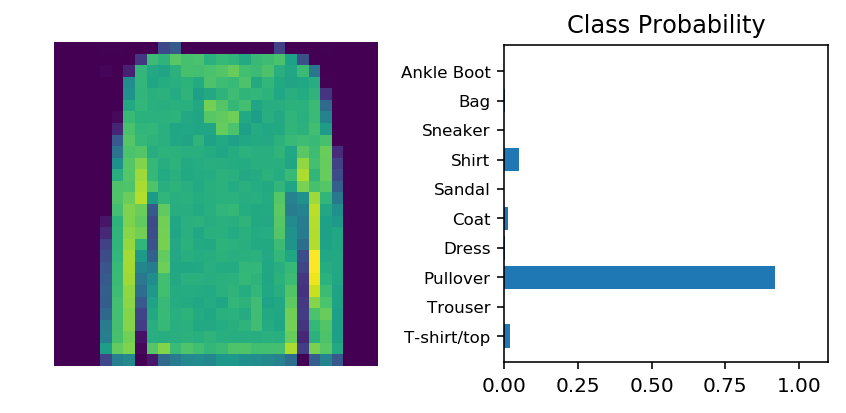

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#import helper

# Test out your network!

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[1]

print('image shape before transpose', img.shape)

# TODO: Calculate the class probabilities (softmax) for img
ps = torch.exp(model(img))

# Plot the image and probabilities
view_classify(img, ps, version='Fashion')

**Author**: Sidney Phoon <br/>
**Date**: 10th Dec 2019